<a href="https://colab.research.google.com/github/elizaliva/CIS-3902-AI-ML-Eliza-Liva-Kalnina/blob/main/Data_Cleaning_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning in Python — A Hands-On Tutorial and Exercise prepared by Dr. Pamela Thompson

**Course:** Intro to Data Mining  
**Your Name:** Eliza Liva Kalnina
**Dataset:** Titanic Passengers (loaded from a public URL, no file downloads needed!)  

---

## Why does data cleaning matter?

Real-world data is *messy*. Before we can build any model or draw any conclusions, we need to:

1. **Understand** the data (shape, types, distributions)
2. **Find problems** (missing values, duplicates, outliers, wrong types)
3. **Fix them** using appropriate strategies

In practice, data scientists spend **60–80 %** of their time on data cleaning and preparation. This notebook walks through the most common cleaning steps using the famous Titanic dataset.

> **Tip:** Run each cell one at a time and read the output before moving on. The goal is to understand *why* we do each step, not just *how*.

---
## 1. Load the Data & Take a First Look

We always start by loading the data and getting a quick overview. The key questions are:
- How many rows and columns?
- What do the first few rows look like?
- What are the column data types?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the full Titanic dataset from a public URL
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Quick peek: shape tells us (rows, columns)
print(f'Dataset shape: {df.shape[0]} rows x {df.shape[1]} columns')

Dataset shape: 891 rows x 12 columns


In [2]:
# .head() shows the first 5 rows — always a good first step
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### What do the columns mean?

| Column | Description |
|--------|-------------|
| PassengerId | Unique ID for each passenger |
| Survived | 0 = No, 1 = Yes (this is what we'd want to predict) |
| Pclass | Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name | Passenger name |
| Sex | male / female |
| Age | Age in years |
| SibSp | # of siblings / spouses aboard |
| Parch | # of parents / children aboard |
| Ticket | Ticket number |
| Fare | Passenger fare |
| Cabin | Cabin number |
| Embarked | Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton |

---
## 2. Understand Data Types & Structure

`.info()` is one of the most useful commands in pandas. It tells us:
- The data type of each column (int, float, object)
- How many **non-null** values each column has (helps spot missing data!)
- Memory usage

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**What to notice above:**
- `Age` has only 714 non-null values out of 891 → missing data!
- `Cabin` has only 204 non-null values → a lot of missing data!
- `Embarked` has 889 non-null values → just 2 missing
- Columns like `Name`, `Sex`, `Ticket` are `object` (text) type

### What is the `object` data type?

In pandas, **`object`** is the default type for columns that contain **text (strings)**. When you see `object` in the `.info()` output, it almost always means that column holds words/labels rather than numbers.

**Why does this matter?** Most machine learning algorithms can **only work with numbers**. They can't do math on words like `"male"` or `"Southampton"`. So before we can use text columns in a model, we need to **convert them to numbers** — a process called **encoding**. We'll do this in Section 6.

Here are the common pandas data types you'll see:

| Dtype | What it means | Example values |
|-------|--------------|----------------|
| `int64` | Whole numbers | 1, 2, 3 |
| `float64` | Decimal numbers | 7.25, 29.5 |
| `object` | Text / strings | "male", "S", "Braund, Mr. Owen" |
| `bool` | True/False | True, False |

### Separate categorical vs. numerical columns

This is important because different column types need different cleaning strategies.
- **Numerical columns** → check for outliers, scale, impute with mean/median
- **Categorical (`object`) columns** → check unique values, encode to numbers, impute with mode

In [4]:
# Identify categorical columns (dtype == 'object' means text/string)
cat_cols = [col for col in df.columns if df[col].dtype == 'object']

# Identify numerical columns
num_cols = [col for col in df.columns if df[col].dtype != 'object']

print('Categorical columns:', cat_cols)
print('Numerical columns: ', num_cols)

Categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical columns:  ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [5]:
# For categorical columns, check how many unique values each has
# This helps us decide which ones are useful for analysis
df[cat_cols].nunique()

,0
Name,891
Sex,2
Ticket,681
Cabin,147
Embarked,3


**Observation:** `Name` (891 unique) and `Ticket` (681 unique) have too many unique values to be useful as categorical features. We'll drop them later.

---
## 3. Descriptive Statistics

`.describe()` gives us summary statistics for numerical columns. Look for:
- Big differences between **mean** and **median (50%)** indicates possible skew or outliers
- **min/max** values that seem unreasonable
- The **count** row (does it match the total number of rows?)

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Things to notice:**
- `Age` count is 714, not 891 which confirms missing values
- `Age` mean (29.7) and median/50% (28.0) are close and roughly symmetric
- `Fare` mean (32.2) is much higher than median (14.5) and right-skewed (some very expensive tickets)
- `Fare` min is 0.0 meaning some passengers paid nothing? Worth investigating

---
## 4. Check for Duplicate Rows

Duplicate rows can bias our analysis. We check for them and remove if needed.

In [7]:
# .duplicated() returns True for each row that is a duplicate of an earlier row
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 0


Good news — no duplicates in this dataset. If there were, we'd remove them with:
```python
df = df.drop_duplicates()
```

---
## 5. Handle Missing Values

This is often the biggest part of data cleaning. We have three main strategies:

| Strategy | When to use |
|----------|------------|
| **Drop the column** | When most values are missing (e.g., > 50%) |
| **Drop the rows** | When very few rows are affected |
| **Fill (impute) the values** | When a moderate amount is missing and we want to keep the data |

Let's first see exactly how much is missing in each column.

In [8]:
# Calculate the percentage of missing values for each column
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_pct = missing_pct.round(2)

print('Percentage of missing values per column:')
print(missing_pct[missing_pct > 0])  # Only show columns with missing values

Percentage of missing values per column:
Age         19.87
Cabin       77.10
Embarked     0.22
dtype: float64


### Step 5a: Drop columns that won't be useful

- `Cabin` is 77% missing — too much to fill reliably. **Drop it.**
- `Name` and `Ticket` have too many unique values to be directly useful. **Drop them.**
- `PassengerId` is just a row identifier, not a real feature. **Drop it.**

In [9]:
# Drop columns that aren't useful for analysis
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_clean = df.drop(columns=cols_to_drop)

print(f'Shape before: {df.shape}')
print(f'Shape after:  {df_clean.shape}')
df_clean.head()

Shape before: (891, 12)
Shape after:  (891, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Step 5b: Handle `Embarked` (only 2 missing values)

Since only 2 rows out of 891 are missing, we can safely drop those rows.

In [10]:
# Drop the 2 rows where Embarked is missing
print(f'Rows before: {len(df_clean)}')
df_clean = df_clean.dropna(subset=['Embarked'])
print(f'Rows after:  {len(df_clean)}')

Rows before: 891
Rows after:  889


### Step 5c: Handle `Age` (about 20% missing)

20% is too much to just drop as we would lose a lot of data. Instead, we'll **impute** (fill in) the missing values.

**Common imputation strategies:**
- **Mean** — good when data is roughly normally distributed
- **Median** — better when data is skewed or has outliers
- **Mode** — used for categorical data

Since Age's mean (29.7) and median (28.0) are close, either works here. We'll use the **median** since it's more robust to outliers.

In [11]:
# Check the mean vs. median of Age before filling
print(f'Age mean:   {df_clean["Age"].mean():.1f}')
print(f'Age median: {df_clean["Age"].median():.1f}')

# Fill missing Age values with the median
df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())

# Verify: no more missing values
print('\nMissing values remaining:')
print(df_clean.isnull().sum())

Age mean:   29.6
Age median: 28.0

Missing values remaining:
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


---
## 6. Encode Categorical Variables

Remember those `object` columns from Section 2? After dropping `Name`, `Ticket`, and `Cabin`, we still have two text columns left: **`Sex`** and **`Embarked`**. Machine learning algorithms need numbers, so we need to convert these text values into numerical form.

There are two common encoding methods:

| Method | How it works | Best for |
|--------|-------------|----------|
| **Label Encoding** | Assigns a number to each category (e.g., male=0, female=1) | Columns with only 2 categories, or categories with a natural order |
| **One-Hot Encoding** | Creates a new column for each category with 0/1 values | Columns with 3+ categories that have no natural order |

> **Why not just use label encoding for everything?** If we encode Embarked as C=0, Q=1, S=2, the model might think S > Q > C (i.e., that there's an order). One-hot encoding avoids this problem.

### 6a: Label Encoding for `Sex` (2 categories)

In [12]:
# Sex has only 2 categories, so label encoding works well
print('Before encoding:')
print(df_clean['Sex'].value_counts())

# Map text to numbers
df_clean['Sex'] = df_clean['Sex'].map({'male': 0, 'female': 1})

print('\nAfter encoding:')
print(df_clean['Sex'].value_counts())

Before encoding:
Sex
male      577
female    312
Name: count, dtype: int64

After encoding:
Sex
0    577
1    312
Name: count, dtype: int64


### 6b: One-Hot Encoding for `Embarked` (3 categories)

In [13]:
# Embarked has 3 categories (C, Q, S) with no natural order → use one-hot encoding
print('Before encoding:')
print(df_clean['Embarked'].value_counts())

# pd.get_dummies() creates one new column per category
# drop_first=True removes one column to avoid redundancy
#   (if it's NOT Embarked_Q and NOT Embarked_S, it must be C)
df_clean = pd.get_dummies(df_clean, columns=['Embarked'], drop_first=True)

print('\nAfter encoding — new columns added:')
df_clean.head()

Before encoding:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

After encoding — new columns added:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,True
1,1,1,1,38.0,1,0,71.2833,False,False
2,1,3,1,26.0,0,0,7.9250,False,True
3,1,1,1,35.0,1,0,53.1000,False,True
4,0,3,0,35.0,0,0,8.0500,False,True


In [14]:
# Check: no more 'object' columns!
print('Data types after encoding:')
print(df_clean.dtypes)
print(f'\nAll columns are now numerical: {all(df_clean.dtypes != "object")}')

Data types after encoding:
Survived        int64
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked_Q       bool
Embarked_S       bool
dtype: object

All columns are now numerical: True


Now every column is numerical and ready for machine learning algorithms.

---
## 7. Detect and Handle Outliers

Outliers are extreme values that are far from the rest of the data. They can distort statistics and model training.

We'll use two common detection methods:
1. **Visual inspection** with box plots
2. **IQR (Interquartile Range) method** — a standard statistical approach

### 7a: Visualize with Box Plots

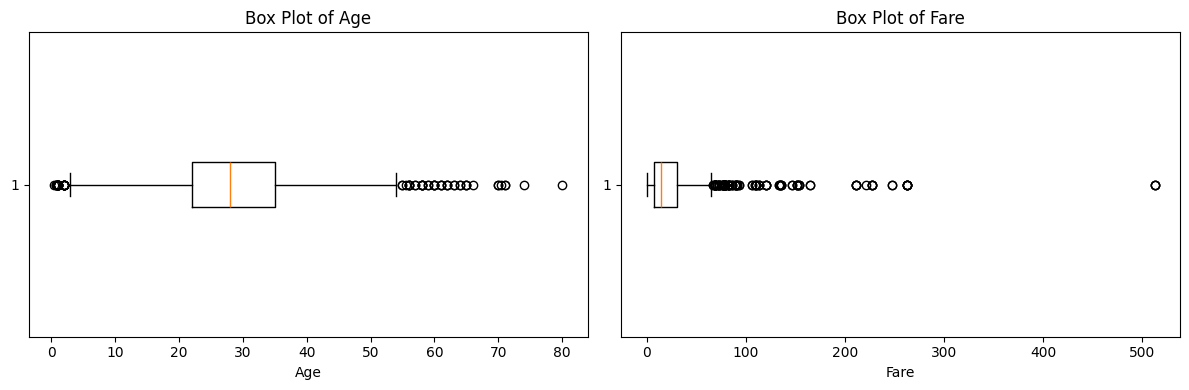

In [15]:
# Box plots for Age and Fare
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].boxplot(df_clean['Age'], vert=False)
axes[0].set_xlabel('Age')
axes[0].set_title('Box Plot of Age')

axes[1].boxplot(df_clean['Fare'], vert=False)
axes[1].set_xlabel('Fare')
axes[1].set_title('Box Plot of Fare')

plt.tight_layout()
plt.show()

The dots beyond the "whiskers" are potential outliers. Notice that `Fare` has some extreme values on the right side.

### 7b: IQR Method for Outlier Detection

The IQR method defines outliers as values that fall below `Q1 - 1.5 × IQR` or above `Q3 + 1.5 × IQR`.

- **Q1** = 25th percentile
- **Q3** = 75th percentile
- **IQR** = Q3 − Q1

In [16]:
def detect_outliers_iqr(data, column):
    """Detect outliers using the IQR method. Returns a boolean mask."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)

    print(f'{column}:')
    print(f'  Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}')
    print(f'  Lower bound = {lower_bound:.2f}, Upper bound = {upper_bound:.2f}')
    print(f'  Number of outliers: {outliers.sum()} ({outliers.sum()/len(data)*100:.1f}%)')
    return outliers

age_outliers = detect_outliers_iqr(df_clean, 'Age')
print()
fare_outliers = detect_outliers_iqr(df_clean, 'Fare')

Age:
  Q1 = 22.00, Q3 = 35.00, IQR = 13.00
  Lower bound = 2.50, Upper bound = 54.50
  Number of outliers: 65 (7.3%)

Fare:
  Q1 = 7.90, Q3 = 31.00, IQR = 23.10
  Lower bound = -26.76, Upper bound = 65.66
  Number of outliers: 114 (12.8%)


### 7c: Remove Outliers from Age

We'll remove Age outliers since they are a small percentage, but see the note below! We'll leave Fare outliers for now. Why? In the Titanic context, expensive first-class tickets are legitimate data points, not errors.<br>

<P>Note: The IQR method divides your data into four quarters. Q1 (22.00) means 25% of passengers are age 22 or younger. Q3 (35.00) means 75% are age 35 or younger. The IQR (13.00) is just Q3 minus Q1; it captures the "middle 50%" of ages, so half the passengers are between 22 and 35.<br><br>
The bounds are where the method draws the line for "too extreme." It takes 1.5 × IQR (1.5 × 13 = 19.5) and extends that distance below Q1 and above Q3. So anything below 2.5 years old or above 54.5 years old gets flagged as an outlier. That gives us 65 passengers (7.3%) labeled as outliers.<br><br>
Here's where it gets interesting: this is a case where the math and the domain context disagree. Is a 60-year-old passenger really an "outlier"? Of course not. Plenty of real people are over 54. The IQR method is just flagging them as statistically unusual relative to this particular dataset, which skews young. And on the low end, labeling toddlers as outliers doesn't make much sense either as children were absolutely on the Titanic.<br><br>
This is exactly the kind of judgment call you need to think about as a data scientist. The IQR method is a useful starting point, but blindly removing every flagged point would mean throwing away passengers which could bias any survival analysis.</P>

> **Important:** Always think about the *domain context* before removing outliers. Not every extreme value is an error!

In [17]:
# Remove Age outliers
print(f'Rows before removing Age outliers: {len(df_clean)}')
df_clean = df_clean[~age_outliers]
print(f'Rows after:                        {len(df_clean)}')

Rows before removing Age outliers: 889
Rows after:                        824


---
## 8. Feature Scaling (Normalization)

Many machine learning algorithms work better when numerical features are on the **same scale**.

| Method | Formula | Range | When to use |
|--------|---------|-------|-------------|
| **Min-Max Scaling** | (x - min) / (max - min) | [0, 1] | When you want bounded values |
| **Standardization** | (x - mean) / std | ~[-3, 3] | When data is roughly normal |

We'll demonstrate Min-Max scaling here.

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Get the numerical columns to scale
# We exclude 'Survived' (target) and the one-hot columns (already 0/1)
num_cols_to_scale = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Make a copy so we don't modify our cleaned data
df_scaled = df_clean.copy()

# Apply Min-Max scaling
scaler = MinMaxScaler()
df_scaled[num_cols_to_scale] = scaler.fit_transform(df_scaled[num_cols_to_scale])

print('Scaled data (first 5 rows):')
df_scaled.head()

Scaled data (first 5 rows):


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,1.0,0,0.372549,0.125,0.0,0.014151,False,True
1,1,0.0,1,0.686275,0.125,0.0,0.139136,False,False
2,1,1.0,1,0.450980,0.000,0.0,0.015469,False,True
3,1,0.0,1,0.627451,0.125,0.0,0.103644,False,True
4,0,1.0,0,0.627451,0.000,0.0,0.015713,False,True


In [19]:
# Verify: all scaled columns should now be between 0 and 1
df_scaled[num_cols_to_scale].describe().round(2)

,Pclass,Age,SibSp,Parch,Fare
count,824.00,824.00,824.00,824.00,824.00
mean,0.67,0.50,0.06,0.06,0.06
std,0.41,0.20,0.14,0.13,0.10
min,0.00,0.00,0.00,0.00,0.00
25%,0.50,0.37,0.00,0.00,0.02
50%,1.00,0.49,0.00,0.00,0.03
75%,1.00,0.61,0.12,0.00,0.06
max,1.00,1.00,1.00,1.00,1.00


---
## 9. Summary: Our Data Cleaning Pipeline

Here's what we did, step by step:

| Step | What we did | Why |
|------|-------------|-----|
| 1 | Loaded data, checked `.head()`, `.shape` | Understand the data |
| 2 | Used `.info()` to check types and non-null counts | Find missing values and type issues |
| 3 | Used `.describe()` for summary statistics | Spot anomalies, understand distributions |
| 4 | Checked for duplicates with `.duplicated()` | Avoid double-counting |
| 5a | Dropped columns: Cabin (77% missing), Name, Ticket, PassengerId | Remove unusable or irrelevant features |
| 5b | Dropped 2 rows with missing Embarked | Very few missing — safe to drop |
| 5c | Filled missing Age with the median | Preserve data; median is robust to outliers |
| 6 | Encoded `Sex` (label) and `Embarked` (one-hot) | Convert text to numbers so algorithms can use them |
| 7 | Detected outliers with IQR; removed Age outliers | Clean extreme values (with domain judgment) |
| 8 | Applied Min-Max scaling to numerical features | Put features on same scale for modeling |